In [1]:
from __future__ import print_function, division
import numpy as np
import netCDF4
from netCDF4 import Dataset
import xarray as xr
import os,datetime,sys,fnmatch
from jdcal import gcal2jd
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime as dt
from matplotlib import gridspec
import pandas as pd

In [36]:
from make_training_images import *

In [37]:
if True:
    #adjust appropriately 
    MOD02_files = [r'/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD02HKM.A2015197.2145.061.2018051030716.hdf']
    MOD06_files = [r'/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD06_L2.A2015197.2145.061.2018051135116.hdf']
    MOD03_files = [r'/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD03.A2015197.2145.061.2018048200537.hdf']
    savedir = r'/home/disk/p/jkcm/plots/measures/train_plots/it_11'

    res = pd.DataFrame(columns=('name', 'date', 'lat', 'lon', 'i', 'j', 'sensor_zenith', 'high_cf', 'low_cf', 'refl_img', 'context_img'))
    for MOD06_file,MOD03_file,MOD02_file in zip(MOD06_files,MOD03_files,MOD02_files):
        # just making sure that all products are using the same granule
        dates = ['.'.join(f.split('.')[-5:-3]) for f in [MOD06_file,MOD03_file,MOD02_file]]
        print('working on ' + dates[1])
        assert dates[0] == dates[1] and dates[1] == dates[2]
    
        var_dict = read_MODIS_level2_data(MOD06_file,MOD03_file,MOD02_file)
        counter = 0
        for i in np.arange(0, var_dict['Ref_band1'].shape[0]-128, 128):
            print('i={}'.format(i))
            for j in np.arange(0, var_dict['Ref_band1'].shape[1]-128, 128):
                print('j={}'.format(j))
                sensor_zenith = nearest_upsample(var_dict['Sensor_Zenith'])[i+64, j+64]
                if sensor_zenith < 45: # sensor zenith angle is fine
                    high_cf, low_cf = cloud_fraction(i,j,nearest_upsample(var_dict['CM']),nearest_upsample(var_dict['CTH']),high_thresh=4000,low_thresh=3000)
                    if high_cf < 0.5 and low_cf > 0.1:  # not too much high cloud, not too little low cloud
                        modis_name, scene_name, context_name = plot_images(var_dict, i, j, modisname=os.path.basename(MOD02_file)[:-4], savedir=savedir)
                        res = res.append([{'name': modis_name, 'date': var_dict['date'], 
                                           'lat': nearest_upsample(var_dict['lat'])[i+64, j+64] ,'lon': nearest_upsample(var_dict['lon'])[i+64, j+64], 'i':i, 'j':j,
                                           'sensor_zenith': sensor_zenith, 'low_cf': low_cf, 'high_cf': high_cf,
                                           'refl_img': scene_name, 'context_img': context_name}])

                    counter+= 1
                if counter > 10:
                    break
            if counter > 10:
                    break
                    print(counter)
            res.to_csv(os.path.join(savedir, 'manifest.csv'), index=False)

working on A2015197.2145
reading the cloud mask from MOD06_L2 product
/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD06_L2.A2015197.2145.061.2018051135116.hdf
level-2 cloud mask array shape (2030, 1354)
reading the lat-lon from MYD03 product
/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD03.A2015197.2145.061.2018048200537.hdf
level-2 lat-lon array shape (2030, 1354)
maximum(Sensor_Zenith) =  65.47
reading the reflectance from MYD02 product
/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD02HKM.A2015197.2145.061.2018051030716.hdf
level-1B reflectance array shape (4060, 2708)
i=0
j=0
j=128
j=256
j=384


/home/disk/p/jkcm/Code/measures-cloud-classifier/make_training_images.py:118: RuntimeWarning: invalid value encountered in less
  CTH_mask = CTH_hr<5000


j=512
j=640
j=768
j=896
j=1024
j=1152
j=1280
j=1408
j=1536
j=1664


In [31]:

def upsample(data, mult=2):
    from scipy import interpolate
    from scipy.interpolate import RectBivariateSpline
    x = np.array(range(data.shape[0]))
    y = np.array(range(data.shape[1]))
#     xx, yy = np.meshgrid(x, y)
#     f = interpolate.interp2d(xx, yy, data, kind='linear')
    print(x.shape)
    print(y.shape)
    print(data.shape)
    interp_spline = RectBivariateSpline(x, y, data, kx=2, ky=2)

    xnew = np.linspace(0, data.shape[0], data.shape[0]*2)
    ynew = np.linspace(0, data.shape[1], data.shape[0]*2)
    x2, y2 = np.meshgrid(xnew,ynew)
    data_upsampled = interp_spline(xnew, ynew)
    return(data_upsampled)

MOD02_file = '/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD02HKM.A2015197.2145.061.2018051030716.hdf'
MOD03_file = r'/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD03.A2015197.2145.061.2018048200537.hdf'
MOD06_file = r'/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD06_L2.A2015197.2145.061.2018051135116.hdf'
var_dict = read_MODIS_level2_data(MOD06_file,MOD03_file,MOD02_file)
# MOD06 = Dataset(MOD06_file, 'r') 
# for k, v in MOD06.variables.items():
#     print(k + str(v.shape))
# MOD06 = Dataset(MOD06_file, 'r')
# MOD06.variables['Cloud_Mask_1km']

reading the cloud mask from MOD06_L2 product
/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD06_L2.A2015197.2145.061.2018051135116.hdf
level-2 cloud mask array shape (2030, 1354)
reading the lat-lon from MYD03 product
/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD03.A2015197.2145.061.2018048200537.hdf
level-2 lat-lon array shape (2030, 1354)
maximum(Sensor_Zenith) =  65.47
reading the reflectance from MYD02 product
/home/disk/eos4/jkcm/Data/MEASURES/new_modis/MYD02HKM.A2015197.2145.061.2018051030716.hdf
level-1B reflectance array shape (4060, 2708)


In [32]:
var_dict['CTH']

array([[13850., 12400., 12050., ...,  -999.,   200.,   200.],
       [13850., 12400., 12050., ...,   450.,   450.,   200.],
       [14200., 13500., 13100., ...,   450.,   450.,   450.],
       ...,
       [ -999.,  -999.,  -999., ...,  1350.,  1350.,  1350.],
       [ -999.,  -999.,  -999., ...,  1350.,  1350.,  1350.],
       [ -999.,  -999.,  -999., ...,  1350.,  1350.,  1350.]])

In [10]:
idx = pd.read_csv(r'/home/disk/p/jkcm/plots/measures/train_plots/it_10/index.csv')

In [30]:
idx[idx.low_cf<0.2]

,name,date,lat,lon,i,j,sensor_zenith,high_cf,low_cf,refl_img,context_img
13,MYD02HKM.A2015197.2145.061.2018051030716.i0_j2048,2015-07-16 21:45:00,18.415371,-129.159363,0,2048,34.66,0.000000,0.189941,MYD02HKM.A2015197.2145.061.2018051030716.i0_j2...,MYD02HKM.A2015197.2145.061.2018051030716.i0_j2...
14,MYD02HKM.A2015197.2145.061.2018051030716.i0_j2176,2015-07-16 21:45:00,18.256710,-130.085800,0,2176,40.76,0.124756,0.139470,MYD02HKM.A2015197.2145.061.2018051030716.i0_j2...,MYD02HKM.A2015197.2145.061.2018051030716.i0_j2...
22,MYD02HKM.A2015197.2145.061.2018051030716.i128_...,2015-07-16 21:45:00,19.617798,-125.227310,128,1280,0.50,0.000000,0.128662,MYD02HKM.A2015197.2145.061.2018051030716.i128_...,MYD02HKM.A2015197.2145.061.2018051030716.i128_...
28,MYD02HKM.A2015197.2145.061.2018051030716.i128_...,2015-07-16 21:45:00,18.989412,-129.302795,128,2048,34.66,0.012939,0.031660,MYD02HKM.A2015197.2145.061.2018051030716.i128_...,MYD02HKM.A2015197.2145.061.2018051030716.i128_...
29,MYD02HKM.A2015197.2145.061.2018051030716.i128_...,2015-07-16 21:45:00,18.832666,-130.232758,128,2176,40.76,0.095215,0.125784,MYD02HKM.A2015197.2145.061.2018051030716.i128_...,MYD02HKM.A2015197.2145.061.2018051030716.i128_...
43,MYD02HKM.A2015197.2145.061.2018051030716.i256_...,2015-07-16 21:45:00,19.545885,-129.449387,256,2048,34.66,0.010254,0.158636,MYD02HKM.A2015197.2145.061.2018051030716.i256_...,MYD02HKM.A2015197.2145.061.2018051030716.i256_...
51,MYD02HKM.A2015197.2145.061.2018051030716.i384_...,2015-07-16 21:45:00,20.844038,-124.882118,384,1152,6.21,0.000000,0.088135,MYD02HKM.A2015197.2145.061.2018051030716.i384_...,MYD02HKM.A2015197.2145.061.2018051030716.i384_...
66,MYD02HKM.A2015197.2145.061.2018051030716.i512_...,2015-07-16 21:45:00,21.415018,-125.010338,512,1152,6.23,0.000000,0.086426,MYD02HKM.A2015197.2145.061.2018051030716.i512_...,MYD02HKM.A2015197.2145.061.2018051030716.i512_...
68,MYD02HKM.A2015197.2145.061.2018051030716.i512_...,2015-07-16 21:45:00,21.240517,-126.233253,512,1408,5.35,0.000000,0.136475,MYD02HKM.A2015197.2145.061.2018051030716.i512_...,MYD02HKM.A2015197.2145.061.2018051030716.i512_...
80,MYD02HKM.A2015197.2145.061.2018051030716.i640_...,2015-07-16 21:45:00,22.071365,-124.517578,640,1024,12.00,0.000000,0.198730,MYD02HKM.A2015197.2145.061.2018051030716.i640_...,MYD02HKM.A2015197.2145.061.2018051030716.i640_...


In [18]:
hcf = idx['high_cf'].values
lcf = idx['low_cf'].values
tot = len(lcf)

(array([363.,  27.,  15.,  14.,   7.,   9.,  10.,   6.,  11.,   3.]),
 array([0.        , 0.09506836, 0.19013672, 0.28520508, 0.38027344,
        0.4753418 , 0.57041016, 0.66547852, 0.76054687, 0.85561523,
        0.95068359]),
 <a list of 10 Patch objects>)

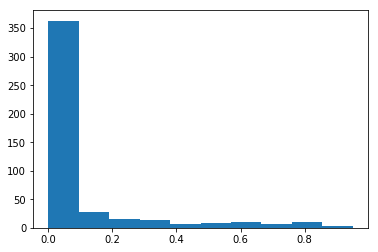

In [38]:
plt.hist(hcf)

In [27]:
100*sum(lcf>0.1)/tot

95.26881720430107

In [ ]:

#     if False:
    
#         # Granule reflectance RGB image with scene box
#         fig1, ax1 = plt.subplots()
#         ax1.imshow(rgb)
#         rect = patches.Rectangle((j,i),128,128,linewidth=1,edgecolor='r',facecolor='none')
#         ax1.add_patch(rect)
#         plt.axis('off')
#         plt.tight_layout()
#     #     fig1.savefig(os.path.join(savedir, modisname+'big_context.png'), dpi=300)

#         # Context reflectance RGB images with scene box
#         imin, imax, jmin, jmax = max(0, i-128), min(rgb.shape[0], i+256), max(0, j-128), min(rgb.shape[1], j+256)
#         fig3, ax3 = plt.subplots()
#         ax3.imshow(rgb[imin:imax, jmin:jmax, :])
#         rect = patches.Rectangle((127,127),128,128,linewidth=1,edgecolor='r',facecolor='none')
#         ax3.add_patch(rect)
#         plt.axis('off')
#         plt.tight_layout()

#         # Scene RGB reflectance image
#         fig2, ax2 = plt.subplots()
#         ax2.imshow(rgb[i:i+128, j:j+128, :])
#         plt.axis('off')
#         plt.tight_layout()

#         # Scene CTH image
#         fig4, ax4 = plt.subplots()
#         cth = ax4.imshow(CTH_hr[i:i+128, j:j+128]/1000)
#         plt.axis('off')
#         cbaxes = inset_axes(ax4, width="5%", height="80%", loc=5) 
#         cb = plt.colorbar(cth, cax=cbaxes)
#         cbaxes.set_ylabel('CTH (km)', backgroundcolor='white')
#         cbaxes.yaxis.set_label_position("left")
#         cbaxes.tick_params(axis="y",direction="in", pad=-12)
#         cbaxes.tick_params(right=False)
#         plt.tight_layout()

#         # Scene RGB reflectance image with CTH mask
#         rgba = (np.concatenate([rgb, CTH_mask[:,:,None]], axis=2))
#         fig5, ax5 = plt.subplots()
#         plt.axis('off')
#         ax5.set_facecolor("lightcoral")
#         plt.tight_layout()
#         ax5.imshow(rgba[i:i+128, j:j+128, :])
#     #     ax5.imshow(CTH_mask[i:i+256, j:j+256])
#         plt.tight_layout()
#     #     fig5.savefig(os.path.join(savedir, 'base_with_mask', modisname+'base_with_mask.png'), dpi=100)

#         # Scene COT image
#         fig6, ax6 = plt.subplots()
#         cot = ax6.imshow(COT_hr[i:i+128, j:j+128])
#         cot2 = ax6.imshow(COT_PCL_hr[i:i+128, j:j+128])
#         plt.axis('off')
#         cbaxes = inset_axes(ax6, width="10%", height="80%", loc=5) 
#         cb = plt.colorbar(cot, cax=cbaxes)
#         cbaxes.set_ylabel('COT', backgroundcolor='white')
#         cbaxes.yaxis.set_label_position("left")
#         cbaxes.tick_params(axis="y",direction="in", pad=-22)
#         cbaxes.tick_params(right=False)
#         plt.tight_layout()

#         fig7, ax7 = plt.subplots()
#         im = ax7.imshow(sen_zen)
#         plt.colorbar(im, ax=ax7)
    
#         print(sen_zen.shape)
#         print(rgb.shape)

    
    
#     for it, fig in zip([1, 2, 3, 4, 5], [fig1, fig2, fig3, fig4, fig5]):
#         fig.savefig(r'/home/disk/p/jkcm/plots/measures/train_plots/it_1/{}.png'.format(it), bbox_inches='tight')